In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import uproot
import h5py as h


In [16]:
def Get_hit_array(file, Current_Event,particle):
    data = h.File(file,'r')
    TotalEvents=int(data['MC']['configuration'][2][1])
    if(TotalEvents < Current_Event):
        print('out of event range')

    Current_Hit_Mask = data['MC']['hits']['event_id'] == Current_Event 
    Current_Particle_Mask = data["MC"]['particles']['event_id'] == Current_Event
    Hits_PIDs=data['MC']['hits'][Current_Hit_Mask]['particle_id'] 
    Current_Particles=data['MC']['particles'][Current_Particle_Mask]

    Electron_Mask = Current_Particles['particle_name'] == particle

    Electron_PIDS = data['MC']['particles'][Current_Particle_Mask][Electron_Mask]['particle_id']

    Hit_Electron_Maks = np.in1d(Hits_PIDs, Electron_PIDS)
    ElectronData=data['MC']['hits'][Current_Hit_Mask][Hit_Electron_Maks]

    return ElectronData


def Diffuser(HIT_ARRAY,ZOFFSET):
    Etotal = 0
    Diffused_X = np.array([])
    Diffused_Y = np.array([])
    Diffused_Z = np.array([])

    for hit in HIT_ARRAY:
        energy_deposit = hit['energy']
        electron_loc_x = hit['x']/10
        electron_loc_y = hit['y']/10
    #     electron_loc_z = hit['z']/10 + Zoffset
        electron_loc_z = ZOFFSET

        Etotal += energy_deposit

        Nelectron = int( (energy_deposit*1e6/GasProps.Wvalue) );

        # Loop through the electrons 
        for electron in range(Nelectron):

            # calculate drift time for diffusion 
            T_drift = electron_loc_z / GasProps.Vd
            if (T_drift <=0):
                print("Warnign T_drift is negative")
                continue
            # electron lifetime
            if (np.random.uniform() >= np.exp(-T_drift/GasProps.Life_Time)):
                continue

            # diffuse the electrons position
            sigma_T = np.sqrt(2*GasProps.Dt*T_drift)
            sigma_L = np.sqrt(2*GasProps.Dl*T_drift)
            electron_x = np.random.normal(electron_loc_x,sigma_T)
            electron_y = np.random.normal(electron_loc_y,sigma_T)
            electron_z = np.random.normal(electron_loc_z,sigma_L)
            Diffused_X=np.append(Diffused_X,electron_x)
            Diffused_Y=np.append(Diffused_Y,electron_y)
            Diffused_Z=np.append(Diffused_Z,electron_z)
    print("evnet has {} MeV and made {} electrons".format(round(Etotal,3), len(Diffused_X)))
        
        
    return Diffused_X, Diffused_Y, Diffused_Z




def Diffuserv2(HIT_ARRAY,ZOFFSET):
    Etotal = 0
    Diffused_X = []
    Diffused_Y = []
    Diffused_Z = []

    for hit in HIT_ARRAY:
        energy_deposit = hit[3]
        electron_loc_x = hit[0]
        electron_loc_y = hit[1]
        #electron_loc_z = hit[2] + Zoffset
        electron_loc_z = ZOFFSET

        Etotal += energy_deposit

       
        # calculate drift time for diffusion 
        T_drift = electron_loc_z / GasProps.Vd
        if (T_drift <=0):
            print("Warnign T_drift is negative")
            continue
        # electron lifetime
        if (np.random.uniform() >= np.exp(-T_drift/GasProps.Life_Time)):
            continue

        # diffuse the electrons position
        sigma_T = np.sqrt(2*GasProps.Dt*T_drift)
        sigma_L = np.sqrt(2*GasProps.Dl*T_drift)
        electron_x = np.random.normal(electron_loc_x,sigma_T)
        electron_y = np.random.normal(electron_loc_y,sigma_T)
        electron_z = np.random.normal(electron_loc_z,sigma_L)
        Diffused_X.append(electron_x)
        Diffused_Y.append(electron_y)
        Diffused_Z.append(electron_z)
    print("evnet has {} MeV and made {} electrons".format(round(Etotal,3), len(Diffused_X)))
        
        
    return Diffused_X, Diffused_Y, Diffused_Z


def ionizationElectronPosition(data,mother,targetvolume='EL_GAP',EventLimit=2):
    TotalEvents=int(data['configuration'][2][1])
    values={}

    
    if(EventLimit>0):
        TotalEvents=EventLimit
        
    for EventID in range(0,EventLimit):
        # obtain current event id
        EventIDMask=data["particles"]["event_id"]==EventID
        
        #store particle infor for this event
        ParticlesTable=data["particles"][EventIDMask]
        # Create Mother mask for expected mother
        MotherMask=ParticlesTable["particle_name"]==mother
        # Interested particles
        IonizationElectronsMask=ParticlesTable["final_volume"]==targetvolume
        #obtain mother ids
        IonizationElectronMotherID=ParticlesTable["mother_id"][IonizationElectronsMask]
        #Expected Mother IDs
        ExpectedMotherID=ParticlesTable["particle_id"][MotherMask]
        # Find intersection of the motherIds of ie and Expected Mother
        MotherIDMask=np.isin(IonizationElectronMotherID,ExpectedMotherID)
        FinalPositions=[ParticlesTable["final_x"][IonizationElectronsMask][MotherIDMask],ParticlesTable["final_y"][IonizationElectronsMask][MotherIDMask],ParticlesTable["final_z"][IonizationElectronsMask][MotherIDMask]]
        values[EventID]=FinalPositions
    return values
        
def getvalues(file):
    data = h.File(file,'r')
    return data['MC']
                
    
class Gas_Properties():
    # gas values for 500V/cm at 10 bar
    # simulated from PyBoltz
    def __init__(self):
        #self.Wvalue = 22.1 # in eV
        #self.Vd = 935000.0 # cm/s
        #self.Dt = 6114.291 # cm**2/s
        #self.Dl = 506.464  # cm**2/s
        #self.Life_Time = 0.001 # in s
        
        self.Wvalue = 22.1 # in eV
        self.Vd = 94000 # cm/s
        self.Dt = 395.80 # cm**2/s
        self.Dl = 61.15  # cm**2/s
        self.Life_Time = 0.001 # in s
        
        
        
GasProps = Gas_Properties()

In [3]:

HITS = Get_hit_array("/home/ilker/Downloads/Pb210.h5", 2,b'alpha')

In [4]:
#ones=np.ones((1,300000))
#test=np.array([0,0,0,1])
#kk=np.meshgrid(test,ones)

In [5]:
print(HITS["x"])

[-16.000439  -15.997945  -15.986983  -15.973759  -15.95707   -15.940885
 -15.931615  -15.919986  -15.909367  -15.902161  -15.890854  -15.882069
 -15.884279  -15.8873005 -15.882338  -15.863705  -15.84134   -15.816531
 -15.811065  -15.806824  -15.807548  -15.807886  -15.810996  -15.811249
 -15.810977 ]


In [6]:
HITS["x"]=HITS["x"]+16
Diff_X, Diff_Y, Diff_Z = Diffuser(HITS, 5)

evnet has 5.304 MeV and made 227466 electrons


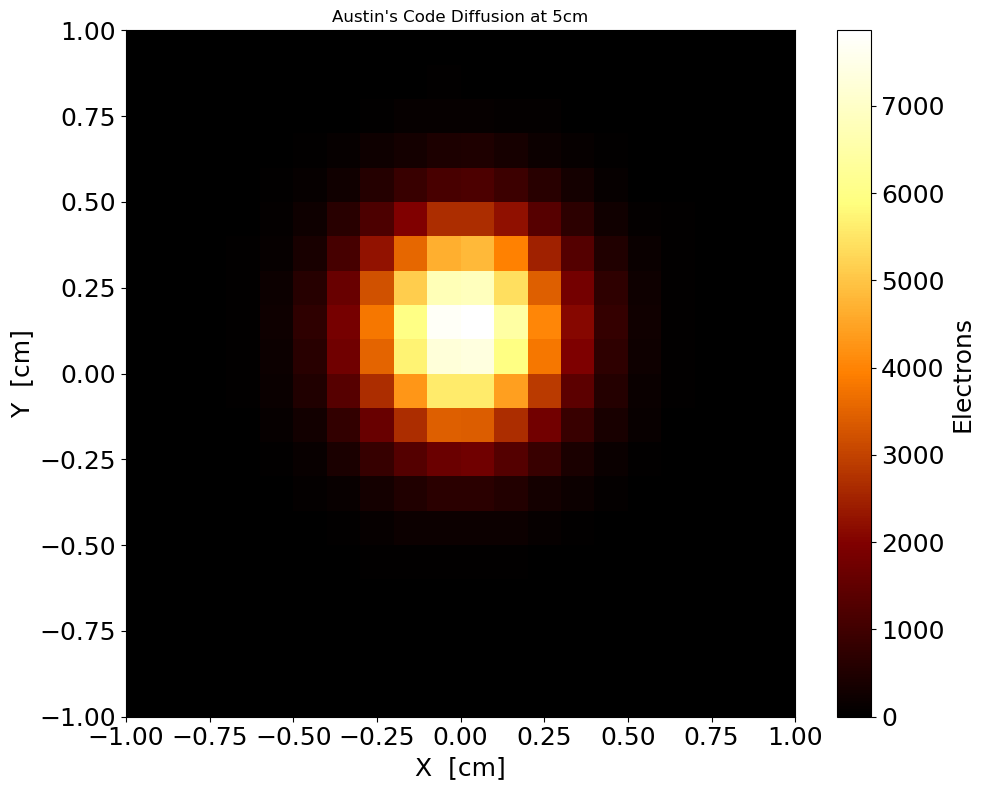

In [25]:

bins = [np.arange(-10, 10, 0.1), np.arange(-10, 10, 0.1)]
cmap = plt.get_cmap('cividis')
cmap = plt.get_cmap('afmhot')

fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(111)
ax1.set_title("Austin's Code Diffusion at 5cm")
h1 = ax1.hist2d(Diff_X, Diff_Y, bins=bins, cmap=cmap)

cbar1 = plt.colorbar(h1[3])
cbar1.set_label('Electrons', fontsize=18)
cbar1.ax.tick_params(labelsize=18)
# cbar1.ax.set_title('Electrons',fontsize=18, rotation=270)

ax1.set_ylabel(r'Y  [cm]',fontsize=18)
ax1.set_xlabel(r'X  [cm]',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.set_xlim(-1,1)
ax1.set_ylim(-1,1)

plt.tight_layout()
# plt.savefig("Reco_Hist.png",dpi=250,bbox_inches='tight')
plt.show()

In [8]:

Diff_X, Diff_Y, Diff_Z = Diffuser(HITS, 5)


evnet has 5.304 MeV and made 227725 electrons


In [9]:
cell_size=0.0016



In [10]:
print(Diff_X)

[0.12172086 0.42521836 0.27929243 ... 0.08096382 0.23178088 0.16302791]


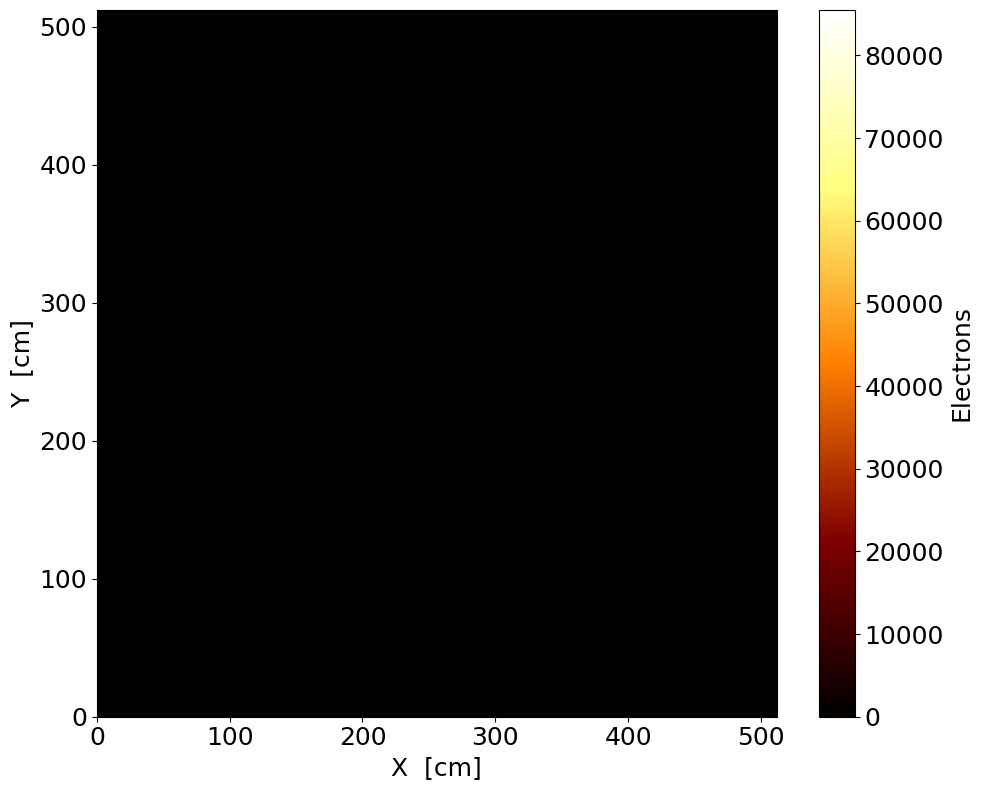

In [11]:
#bins = [np.linspace(0, 512, 512), np.linspace(0, 512, 512)]
bins = [np.linspace(0, 512, 512), np.linspace(0, 512, 512)]
cmap = plt.get_cmap('cividis')
cmap = plt.get_cmap('afmhot')

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

h1 = ax1.hist2d(Diff_X, Diff_Y, bins=bins, cmap=cmap)

cbar1 = plt.colorbar(h1[3])
cbar1.set_label('Electrons', fontsize=18)
cbar1.ax.tick_params(labelsize=18)
# cbar1.ax.set_title('Electrons',fontsize=18, rotation=270)

ax1.set_ylabel(r'Y  [cm]',fontsize=18)
ax1.set_xlabel(r'X  [cm]',fontsize=18)
ax1.tick_params(labelsize=18)

plt.tight_layout()
# plt.savefig("Reco_Hist.png",dpi=250,bbox_inches='tight')
plt.show()

In [22]:
### GEANT4

Event=1

In [13]:
filePath="/home/ilker/Downloads/Pb210_withdiffusion.h5"


In [14]:
data=getvalues(filePath)

In [17]:
Alphaies=ionizationElectronPosition(data,b'alpha',b'EL_GAP',2)

In [23]:
X=(Alphaies[Event][0]+16)/10
Y=Alphaies[Event][1]/10

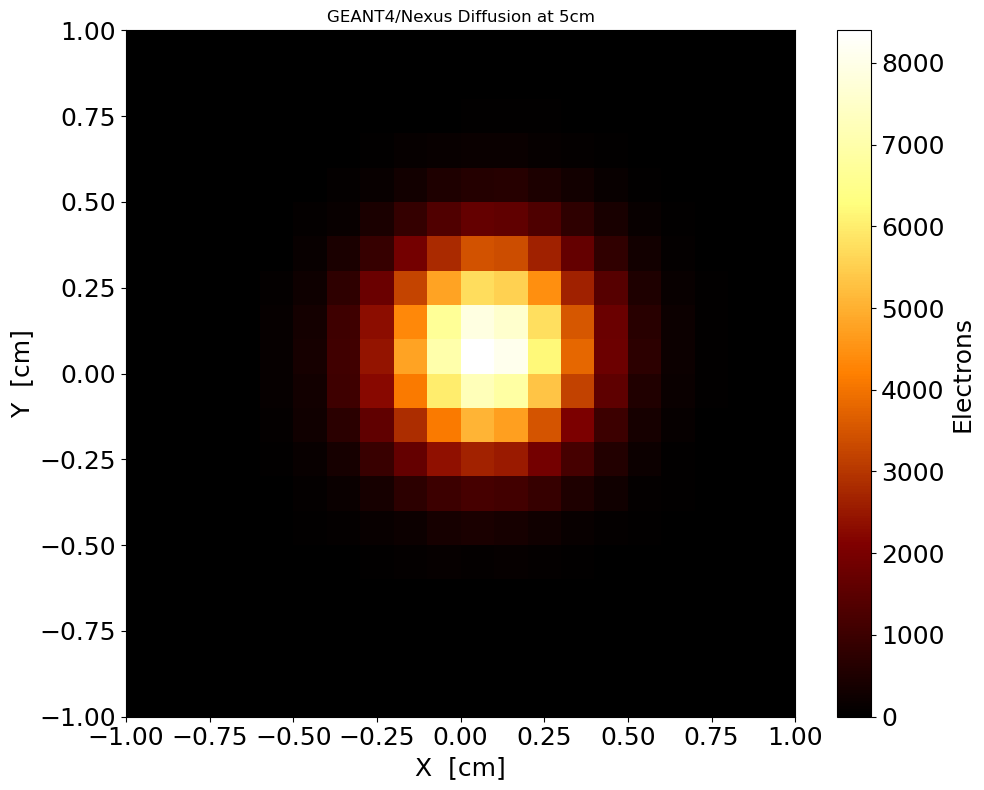

In [27]:

bins = [np.arange(-10, 10, 0.1), np.arange(-10, 10, 0.1)]
cmap = plt.get_cmap('cividis')
cmap = plt.get_cmap('afmhot')

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)
ax1.set_title("GEANT4/Nexus Diffusion at 5cm")


h1 = ax1.hist2d(X, Y, bins=bins, cmap=cmap)

cbar1 = plt.colorbar(h1[3])
cbar1.set_label('Electrons', fontsize=18)
cbar1.ax.tick_params(labelsize=18)
# cbar1.ax.set_title('Electrons',fontsize=18, rotation=270)

ax1.set_ylabel(r'Y  [cm]',fontsize=18)
ax1.set_xlabel(r'X  [cm]',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.set_xlim(-1,1)
ax1.set_ylim(-1,1)

plt.tight_layout()
# plt.savefig("Reco_Hist.png",dpi=250,bbox_inches='tight')
plt.show()